In [1]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx
import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt
import torch.nn as nn
import glob
import random

In [2]:
torch.cuda.is_available()

True

In [4]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    return [(i, j) for i in range(size) for j in range(i + 1, size)]

def node2edge(node_pos, batch):
    # find sizes for each graph in batch
    graph_sizes = list(map(lambda d: d.x.size()[0], batch.to_data_list()))
    # get split indices
    start_idx = np.insert(np.cumsum(graph_sizes), 0, 0)
    start_pos = []
    end_pos = []
    for i, num_nodes in enumerate(graph_sizes):
        # get edge list for current graph
        edgelist = np.array(generate_edgelist(num_nodes))
        # get node positions for current graph
        graph_node_pos = node_pos[start_idx[i]:start_idx[i+1]]
        # get edge start positions for current graph
        start_pos += [graph_node_pos[edgelist[:, 0]]]
        # get edge end positions for current graph
        end_pos += [graph_node_pos[edgelist[:, 1]]]
    # concatenate the results
    return torch.cat(start_pos, 0), torch.cat(end_pos, 0)

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        start = "n" + str(i[0])
        end = "n" + str(i[1])
        d = path_length[start][end]
        l = L * d #l = L * d
        k = K/(d**2) 
        start_degree = G.degree(start)
#         end_degree = G.degree(end)
        edge_attr.append([l,k,start_degree])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size):
    while True:
        G = nx.binomial_graph(size, random.uniform(0,0.2),directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

def generate_testgraph(size,prob):
    while True:
        G = nx.binomial_graph(size, prob,directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data_batch):
        energy = 0
        offset = 0
        for data in data_batch.to_data_list():
            edge_attr = data.edge_attr
            n = data.x.size()[0]
            x = p[offset:offset+n, 0]
            y = p[offset:offset+n, 1]
            offset += n
            l = edge_attr[:, 0]
            k = edge_attr[:, 1]
            for e, (i, j) in enumerate(generate_edgelist(n)):
                term1 = (x[i] - x[j]) ** 2
                term2 = (y[i] - y[j]) ** 2
                term3 = l[e] ** 2
                term4 = 2 * l[e] * (term1 + term2).sqrt()
                energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy

    
class EnergyLossVectorized(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end = node2edge(p, data)
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()
    
def train(model, criterion, optimizer,loader):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(data_list)

def evaluate(model,data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach().cpu().numpy()
    return pred

def load_rome(ngraph):
    files = glob.glob('rome/*.graphml')
    random.shuffle(files)
    G_list = []
    count = 0
    for file in files:
        G = nx.read_graphml(file)
        G_list.append(G)
    return G_list

def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 16, Linear(3,2*16))
        self.conv2 = NNConv(16, 16, Linear(3, 16*16))
        self.conv3 = NNConv(4*16, 2, Linear(3, 4*16*2))
        self.relu = nn.LeakyReLU()
#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.relu(self.conv1(x, edge_index, edge_attr))
        x2 = self.relu(self.conv2(x1, edge_index, edge_attr))
        x3 = self.relu(self.conv2(x2, edge_index, edge_attr))
        x4 = self.relu(self.conv2(x3, edge_index, edge_attr))
        x5 = torch.cat((x1, x2, x3, x4), dim=1)
        x6 = self.conv3(x5, edge_index, edge_attr)
#         x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
#         x5 = F.relu(self.conv5(x4,edge_index,edge_attr))
        return x6


def convert_datalist(rome,ngraph):
    count = 0
    data_list = []
    G_list = []
    for G in rome:
        size = len(G.nodes())
        com_edge_list = generate_edgelist(G.size())
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(G.size())
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        count += 1
        print(count)
        data_list.append(data)
        G_list.append(G)
        if count >= ngraph:
            return G_list,data_list
    return G_list,data_list

In [68]:
#generate random graph
ngraph = 1000
ngraph_size = [random.randint(20,40) for i in range(ngraph)]
data_list = []
for i in range(ngraph):
    G, data = generate_graph(ngraph_size[i])
    data_list.append(data)

In [5]:
#load specific number of graph from rome dataset
ngraph = 1000
rome = load_rome(ngraph)

In [6]:
G_list,data_list = convert_datalist(rome,ngraph)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
loader = DataLoader(data_list[:-1], batch_size=32,shuffle=True)
loss_ep = []


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


10 1.7899639855656616e+16
20 11110244973884.777
30 2677440757799.29
40 827754242774.8682
50 294421432393.66907
60 114056258734.35011
70 46713774747.93285
80 19853811574.484413
90 8341855268.834533
100 3543376355.760192
110 1518977869.9664268
120 669013303.2517985
130 298007114.28297365
140 130879020.54676259
150 58868400.306954436
160 25612662.56115108
170 11578206.091127098
180 5502590.611510792
190 2664576.4796163067
200 1355701.6103117506


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


210 736617.4208633094
220 420977.4835131894
230 243305.94724220622
240 142393.67191247002
250 84227.60836330935
260 50187.90804856115
270 30216.537320143885
280 18243.190310251797
290 10978.15456384892
300 6699.4923280125895
310 4250.548263732764
320 2691.7116049348024
330 1731.3520683453237
340 1108.6541493367806
350 723.1790885650854
360 469.2146446904976
370 312.96053118442745
380 218.6003898053432
390 159.39747381782075
400 123.9754343009967
410 104.8805274140063
420 94.00242794046014
430 87.9983454642536
440 85.3309147603792
450 84.72202452881444
460 85.24071153233663
470 86.45263613328088
480 88.03468494735462
490 89.70471864695743
500 91.37565513995054
510 92.81994423992056
520 94.16223700726918
530 95.3902005348846
540 96.50333893041817
550 97.50569837099071
560 98.39493990744904
570 99.18516690553807
580 99.87979791947691
590 100.48865536477068
600 101.0222191387515
610 101.44525044027279
620 101.81545486267237
630 102.14331932891187
640 102.43135550153627
650 102.684000651041

KeyboardInterrupt: 

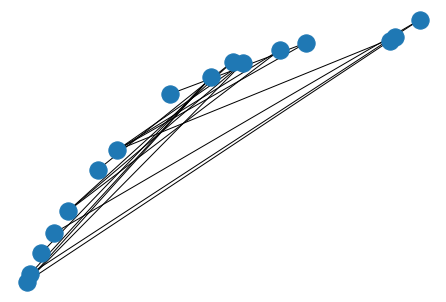

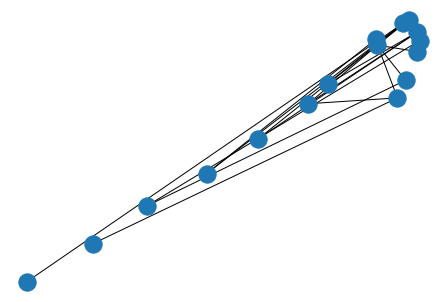

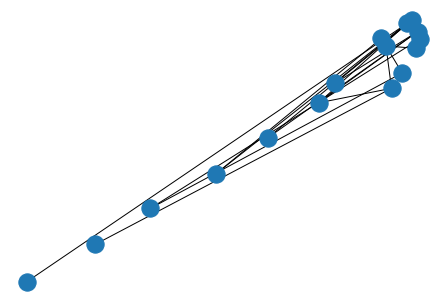

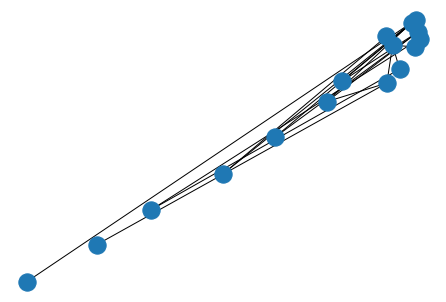

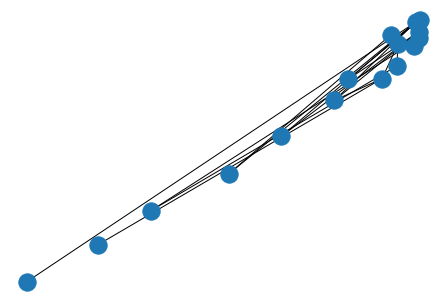

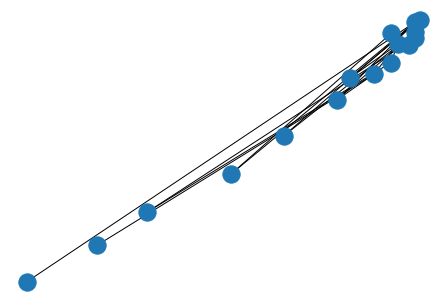

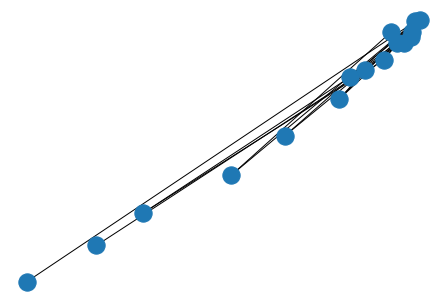

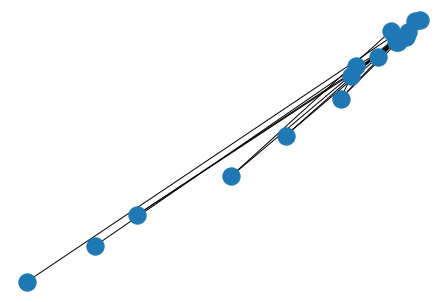

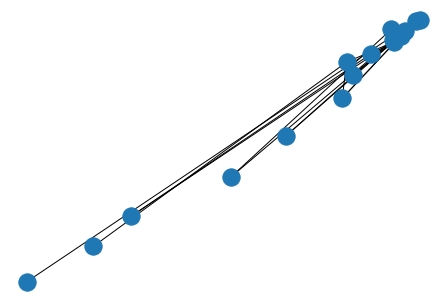

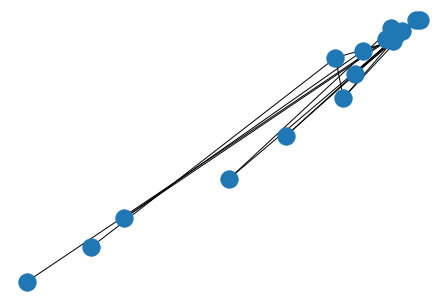

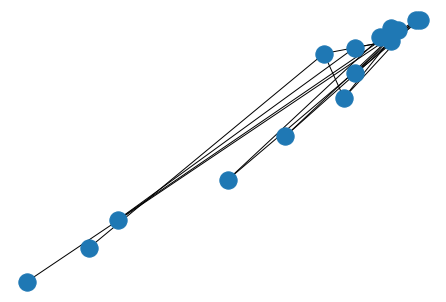

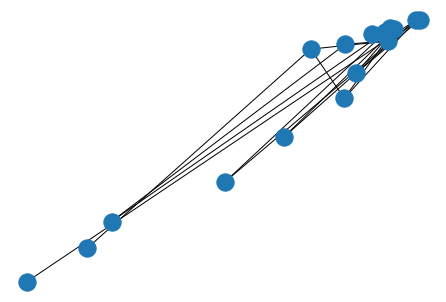

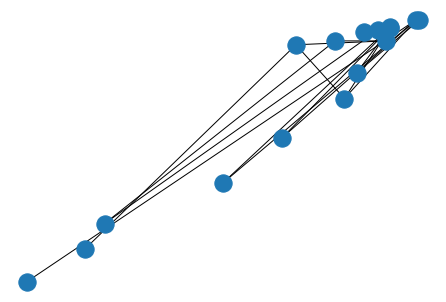

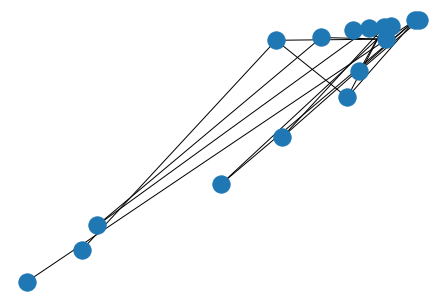

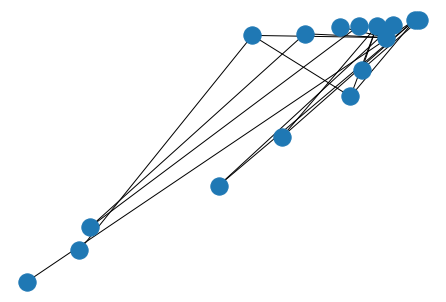

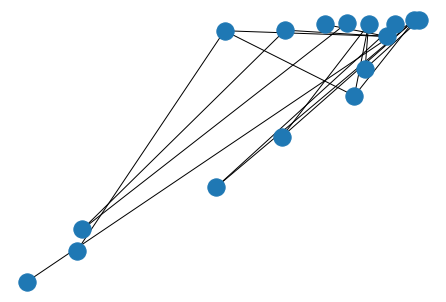

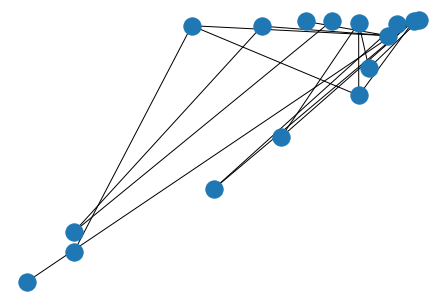

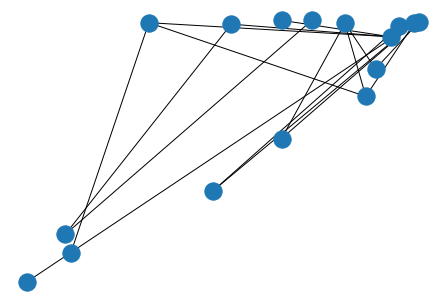

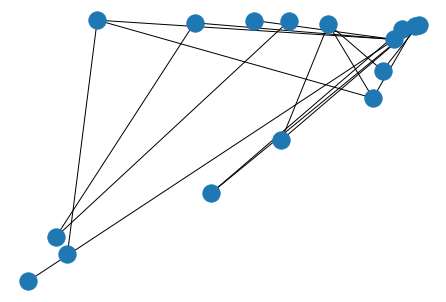

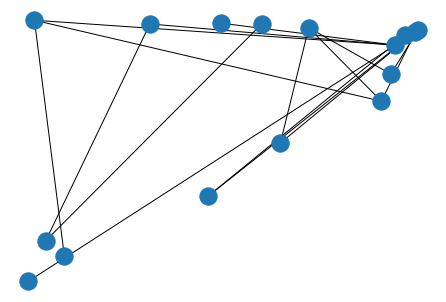

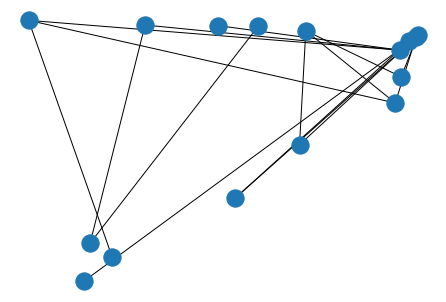

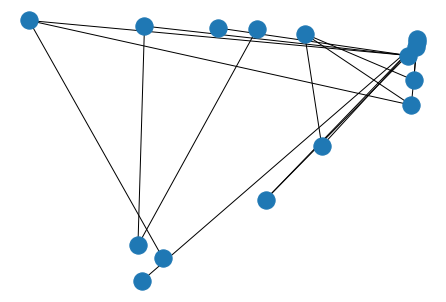

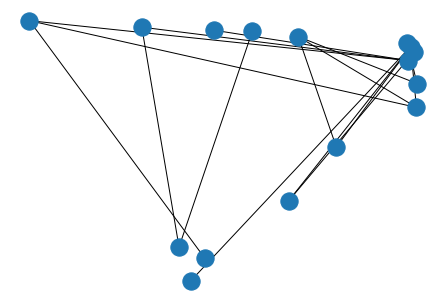

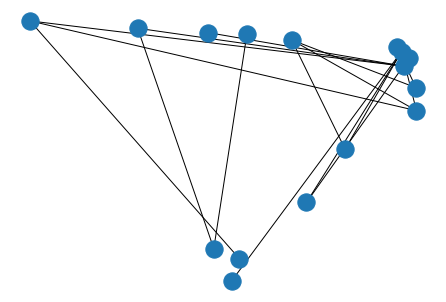

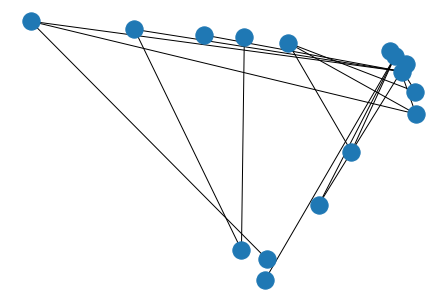

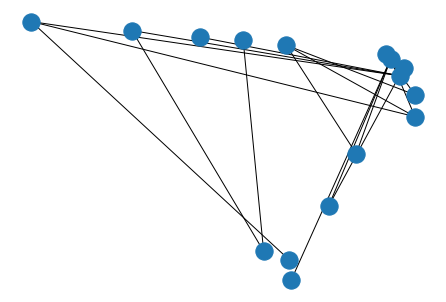

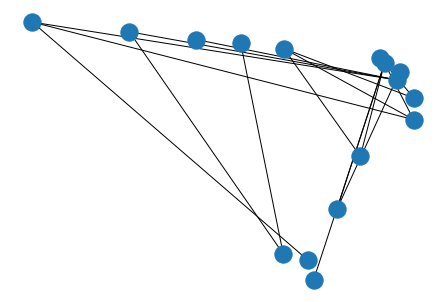

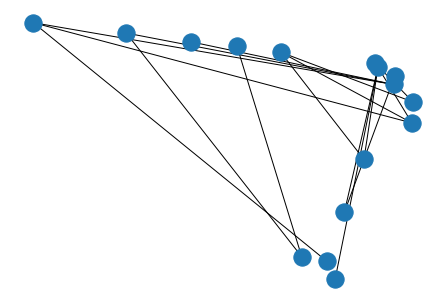

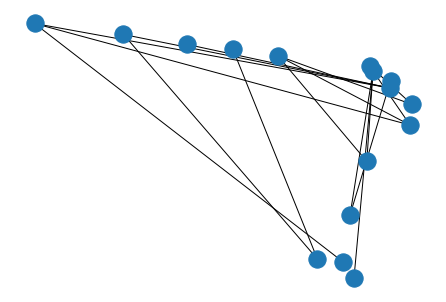

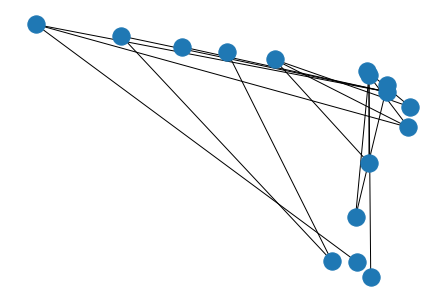

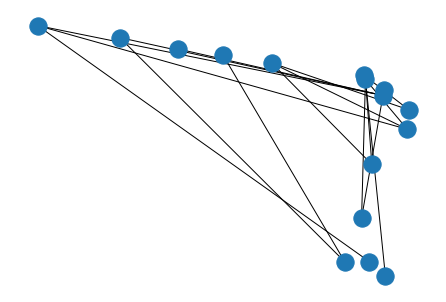

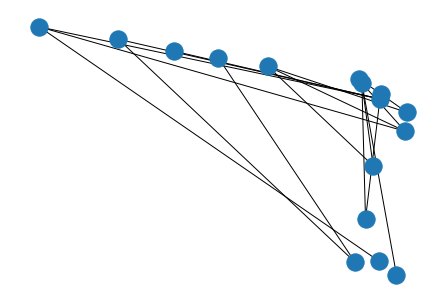

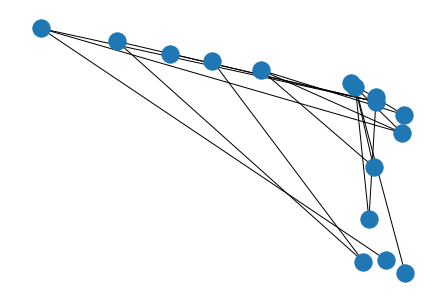

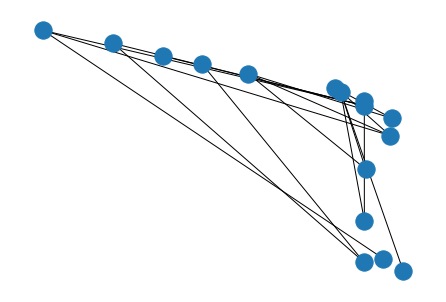

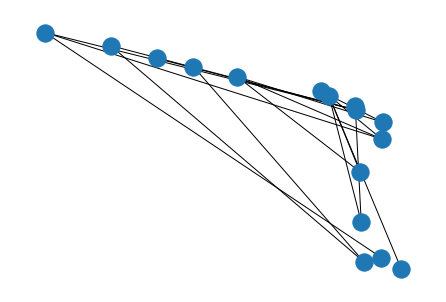

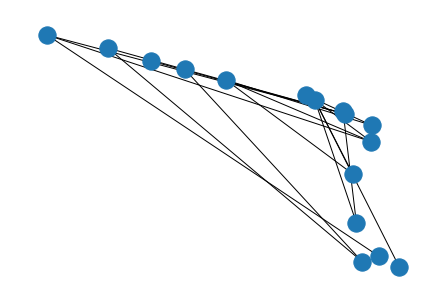

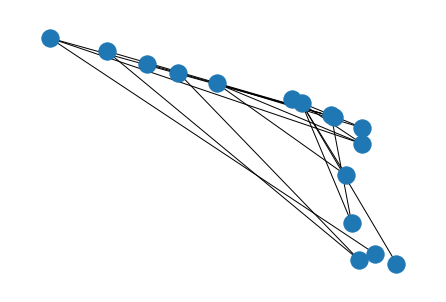

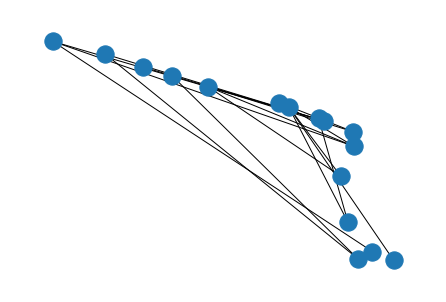

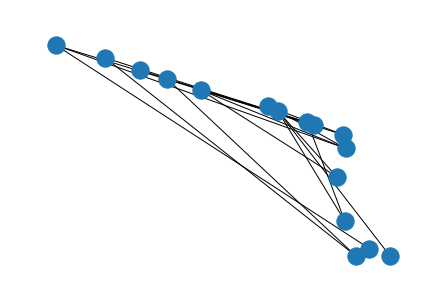

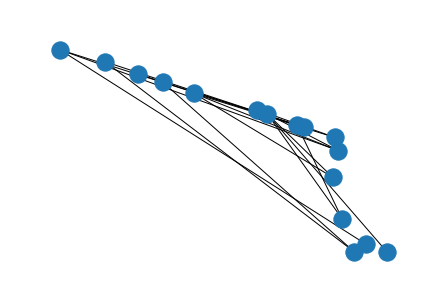

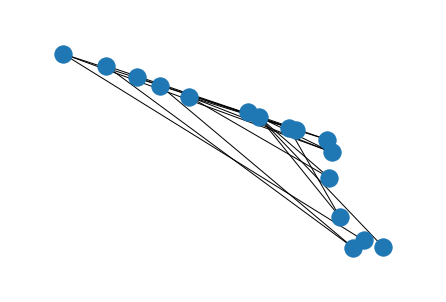

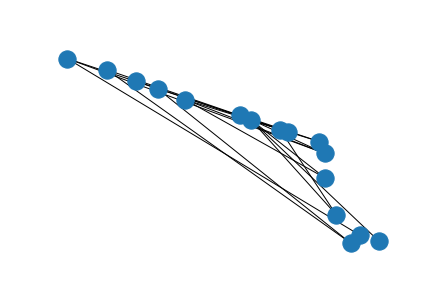

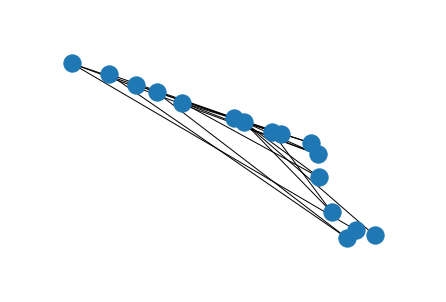

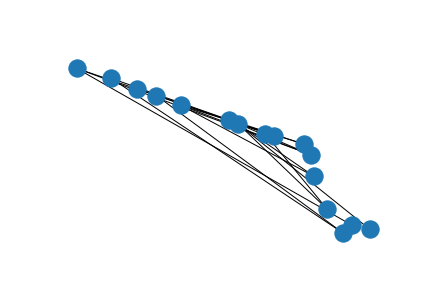

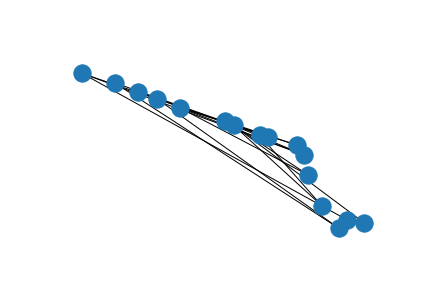

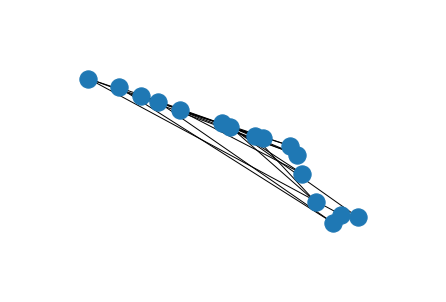

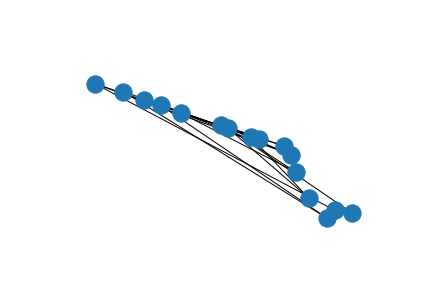

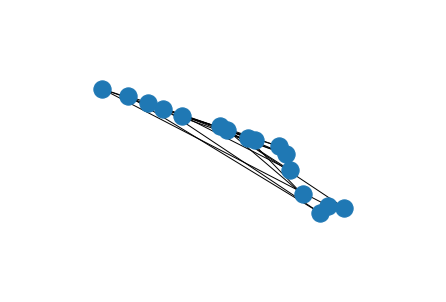

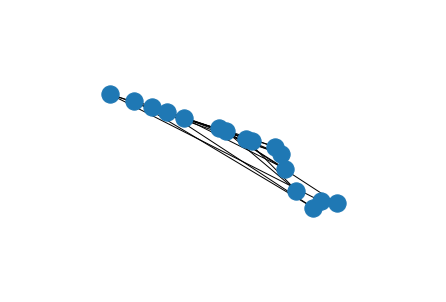

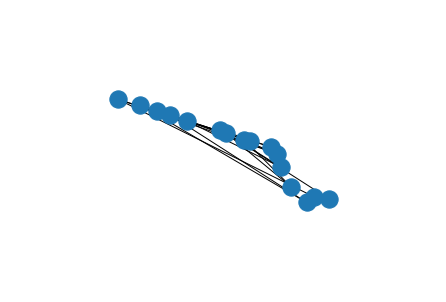

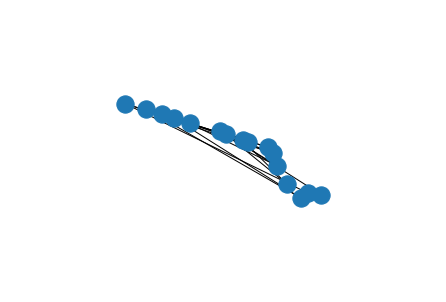

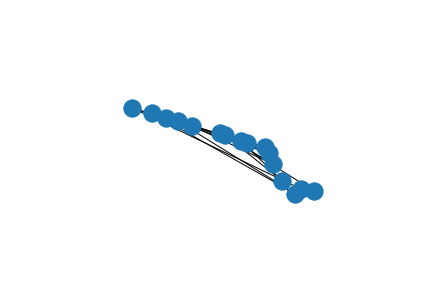

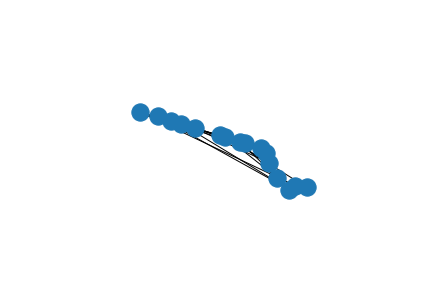

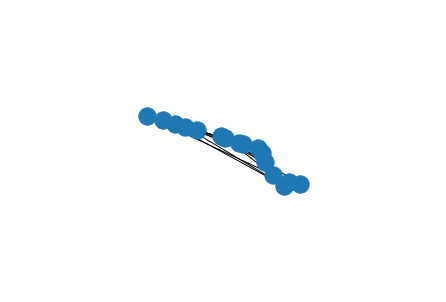

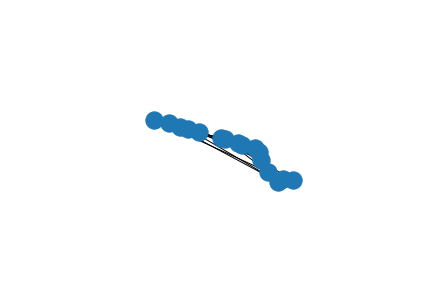

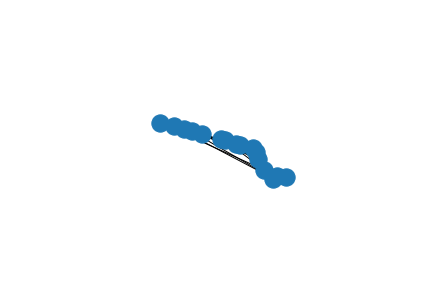

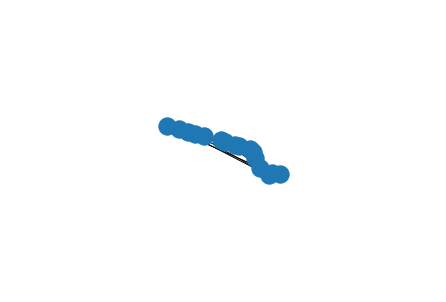

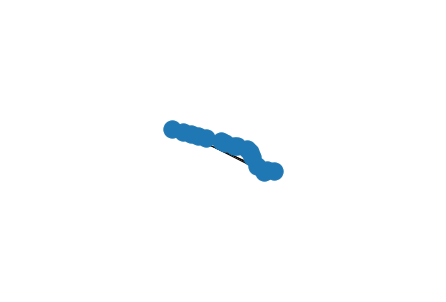

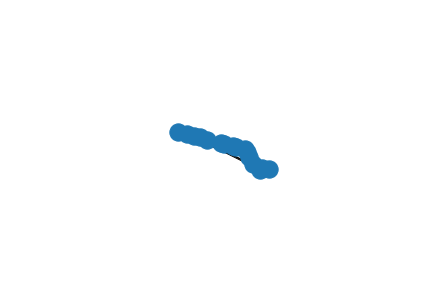

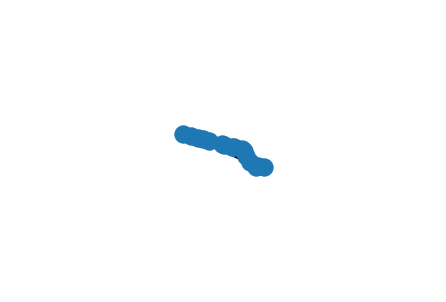

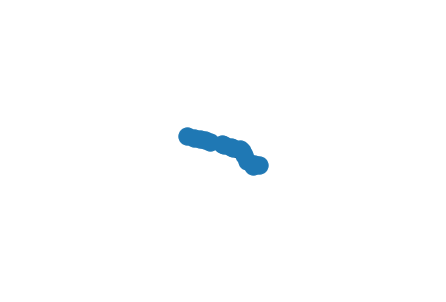

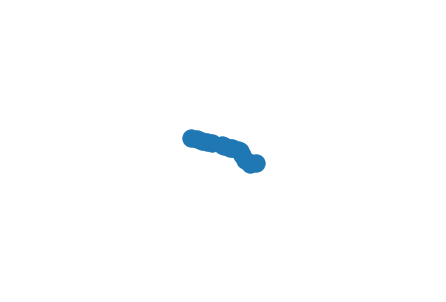

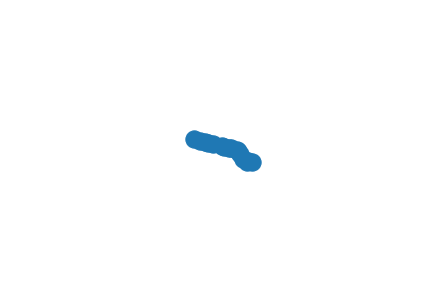

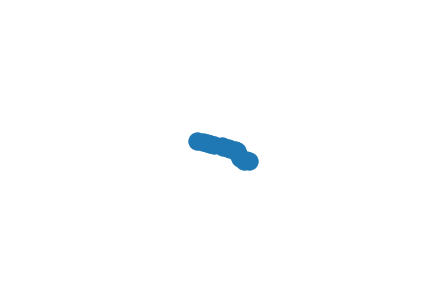

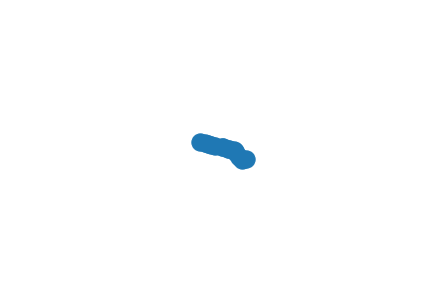

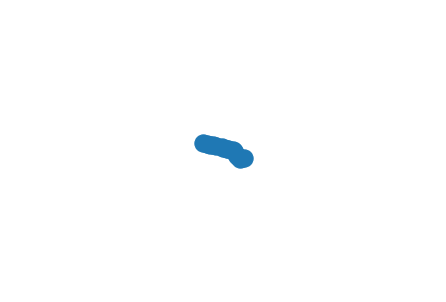

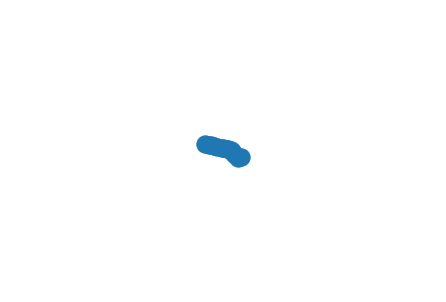

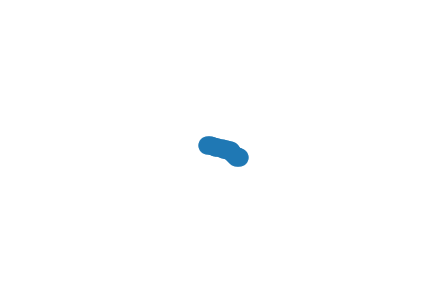

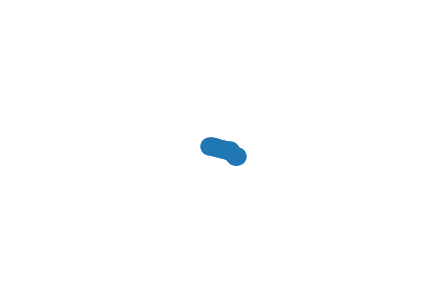

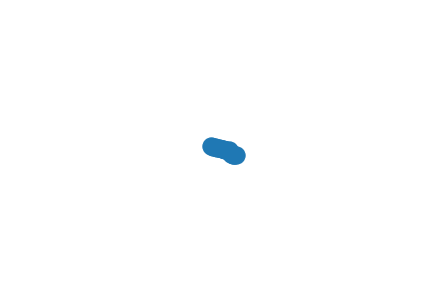

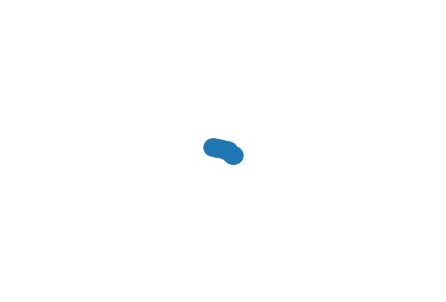

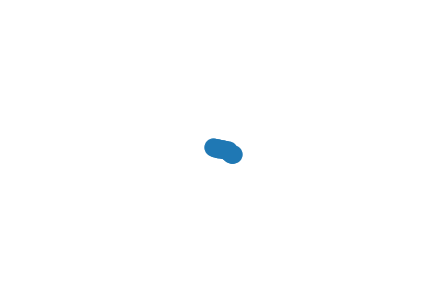

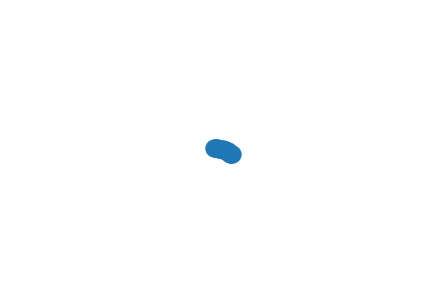

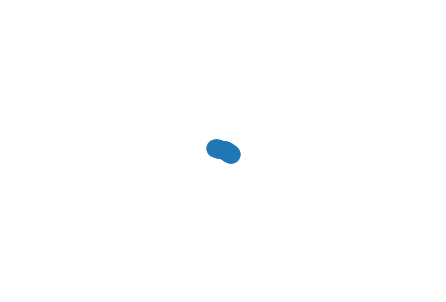

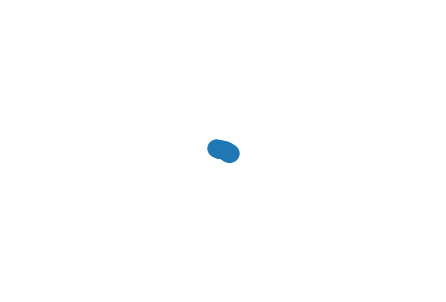

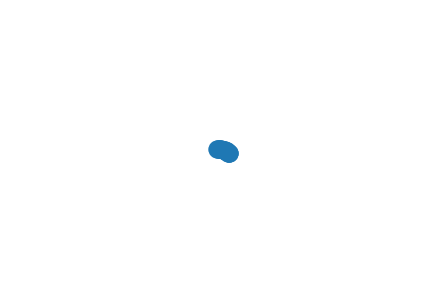

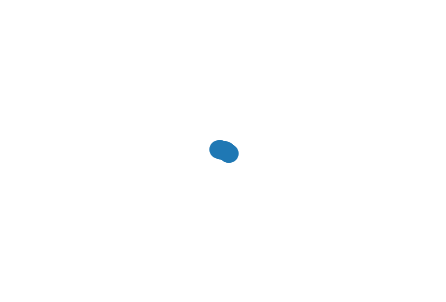

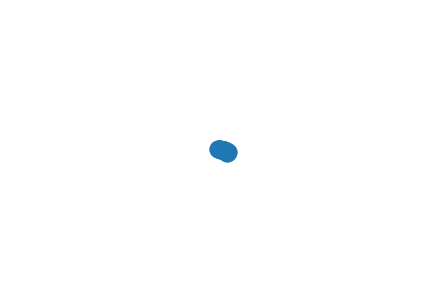

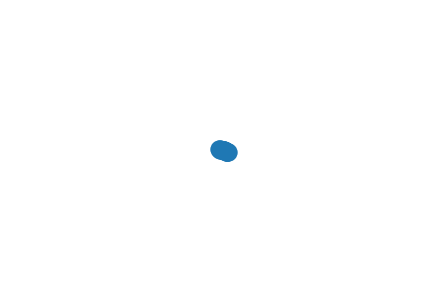

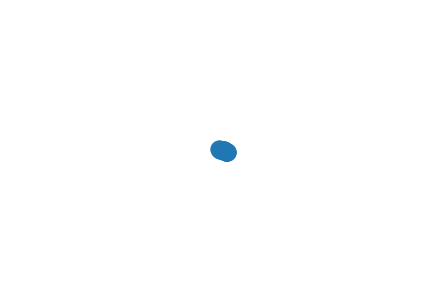

In [11]:
start_epoch = 1
num_epochs = 11000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if start_epoch == 1:
    model = Net().to(device)
else:
    model = torch.load(f'ckpt_rome_degree/epoch_{start_epoch}.pt').to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, 0.9)
for epoch in range(start_epoch, num_epochs):
    loss = train(model, criterion, optimizer,loader)
    loss_ep.append(loss)
    scheduler.step()
    if epoch % 10 == 0:
        torch.save(model, f'ckpt_rome_degree/epoch_{epoch}.pt')
        node_pos = evaluate(model, data_list[-1])
        graph_vis(G_list[-1], node_pos, f'rome_degree/epoch_{epoch}.png')
        print(epoch, loss)

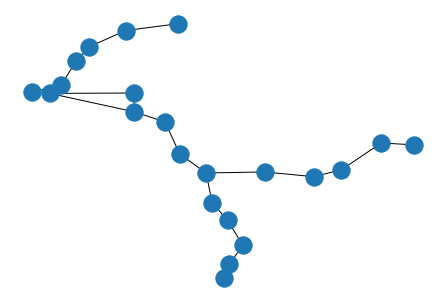

In [27]:
G_vis = G_list[400]
node_pos = evaluate(model, data_list[400])
graph_vis(G_vis, node_pos, f'model_400.png') 

In [28]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
A = to_agraph(G_vis)
A.layout('neato')
A.draw('400.png')


/opt/conda/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Error: node n0, position (-0.16055506, 0.41661245), expected two doubles
Error: node n21, position (-0.05161597, 0.47404757), expected two doubles
Error: node n1, position (0.5575079, -1.0349363), expected two doubles
Error: node n10, position (0.5787296, -0.92867583), expected two doubles
Error: node n2, position (0.8947292, -0.2434934), expected two doubles
Error: node n7, position (0.999098, -0.18939644), expected two doubles
Error: node n11, position (0.71067417, -0.20642143), expected two doubles
Error: node n3, position (-0.094492525, 0.4079295), expected two doubles
Error: node n12, position (0.22290267, 0.41081205), expected two doubles
Error: node n14, position (0.22179425, 0.26433975), expected two doubles
Error: node n4, position (0.6293701, -0.7793664), expected two doubles
Error: node n18, position (0.5721825, -0.585411), expected two doubles
Error: node n5, position (0.49193278, -0.21451975)

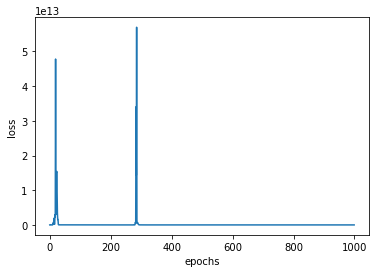

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()